In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn, os,csv
from scipy.io import arff
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
import optuna
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
os.listdir("/kaggle/input/taskdata/Multi-Variate/Multi-Variate")

['eye state',
 'occupancy+detection',
 'individual household electric ower consumption']

In [3]:
source='/kaggle/input/taskdata/Multi-Variate/Multi-Variate/individual household electric ower consumption/household_power_consumption.txt'

In [4]:
df = pd.read_csv(source, sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [5]:
Features =['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1','Sub_metering_2','Sub_metering_3']

In [6]:
  def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
df=reduce_mem_usage(df)

Mem. usage decreased to 71.25 Mb (43.8% reduction)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float32
 1   Global_reactive_power  float32
 2   Voltage                float32
 3   Global_intensity       float32
 4   Sub_metering_1         float32
 5   Sub_metering_2         float32
 6   Sub_metering_3         float32
dtypes: float32(7)
memory usage: 71.2 MB


In [9]:
df.dtypes, df.shape

(Global_active_power      float32
 Global_reactive_power    float32
 Voltage                  float32
 Global_intensity         float32
 Sub_metering_1           float32
 Sub_metering_2           float32
 Sub_metering_3           float32
 dtype: object,
 (2075259, 7))

In [10]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [11]:
df.min(),df.mean(),df.mode(), df.max(),

(Global_active_power        0.076000
 Global_reactive_power      0.000000
 Voltage                  223.199997
 Global_intensity           0.200000
 Sub_metering_1             0.000000
 Sub_metering_2             0.000000
 Sub_metering_3             0.000000
 dtype: float32,
 Global_active_power        1.091615
 Global_reactive_power      0.123714
 Voltage                  240.839859
 Global_intensity           4.627760
 Sub_metering_1             1.121923
 Sub_metering_2             1.298520
 Sub_metering_3             6.458447
 dtype: float32,
    Global_active_power  Global_reactive_power     Voltage  Global_intensity  \
 0                0.218                    0.0  241.179993               1.0   
 
    Sub_metering_1  Sub_metering_2  Sub_metering_3  
 0             0.0             0.0             0.0  ,
 Global_active_power       11.122000
 Global_reactive_power      1.390000
 Voltage                  254.149994
 Global_intensity          48.400002
 Sub_metering_1            88.0

In [8]:
def fill_with_mean(column):
    return column.fillna(column.mean())

df = df.apply(fill_with_mean, axis=0)

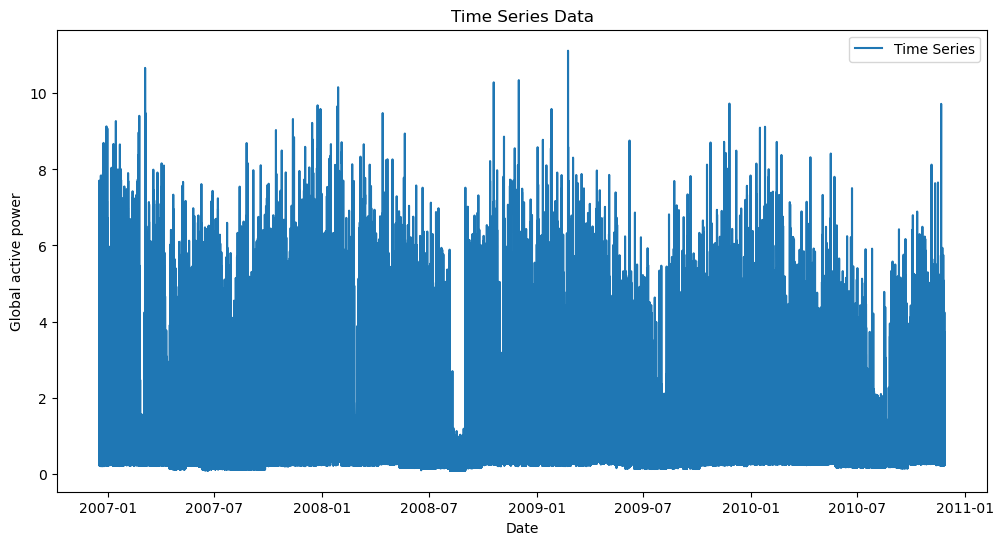

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Global_active_power'], label='Time Series')
plt.xlabel('Date')
plt.ylabel('Global active power')
plt.title('Time Series Data')
plt.legend()
plt.show()

In [7]:
df1=df[:575259]

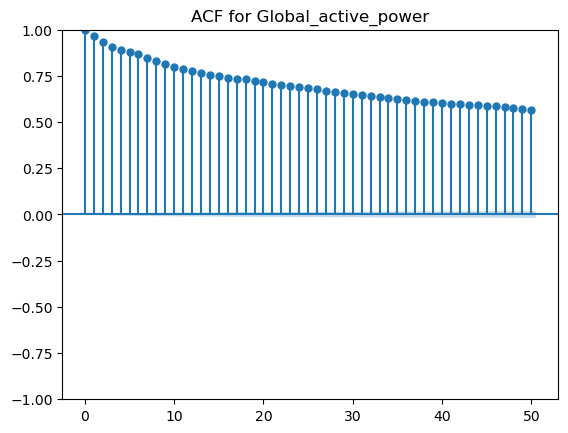

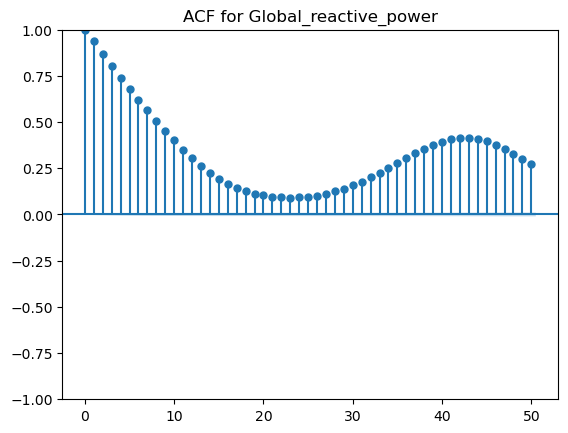

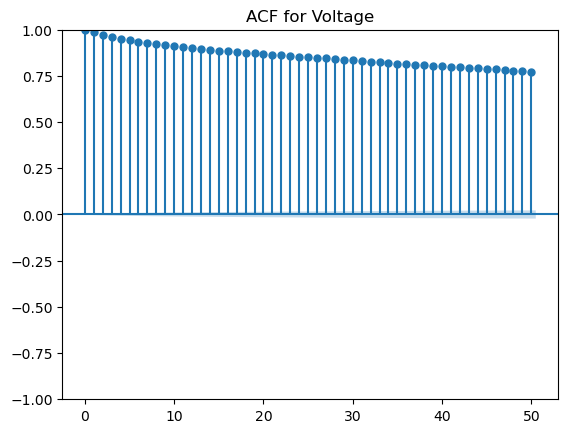

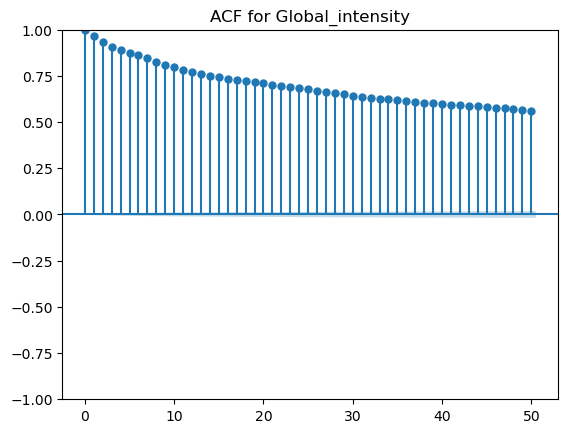

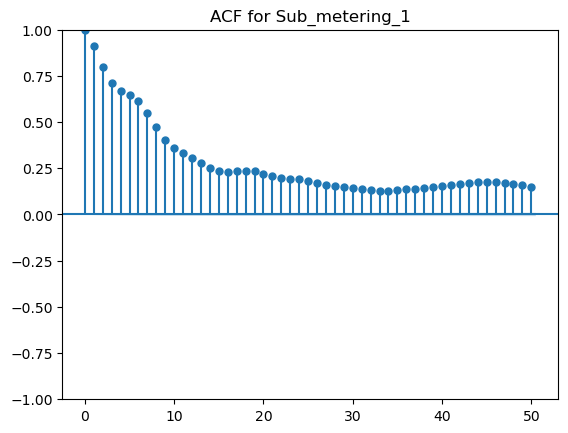

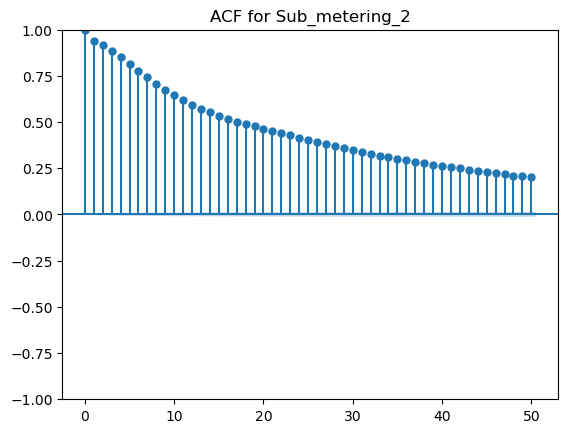

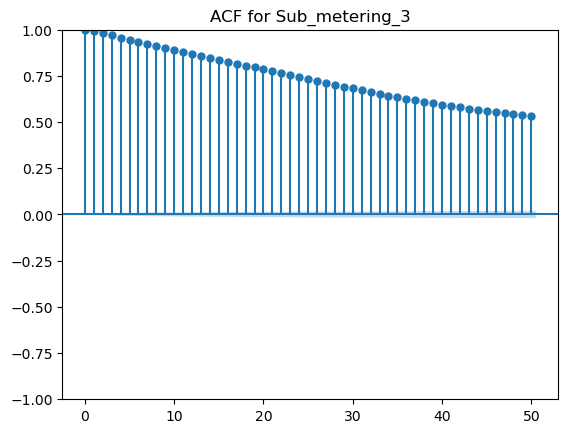

In [ ]:
for column in df1.columns:
    sm.graphics.tsa.plot_acf(df1[column].dropna(), lags=50)
    plt.title(f"ACF for {column}")
    plt.show()

# Combine all columns into a single series for multivariate ACF
combined_series = df1.stack().reset_index(drop=True)

# Calculate multivariate ACF
sm.graphics.tsa.plot_acf(combined_series, lags=50)
plt.title("Multivariate ACF")
plt.show()

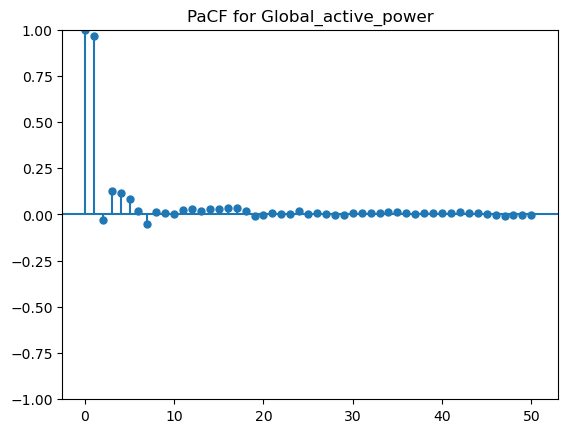

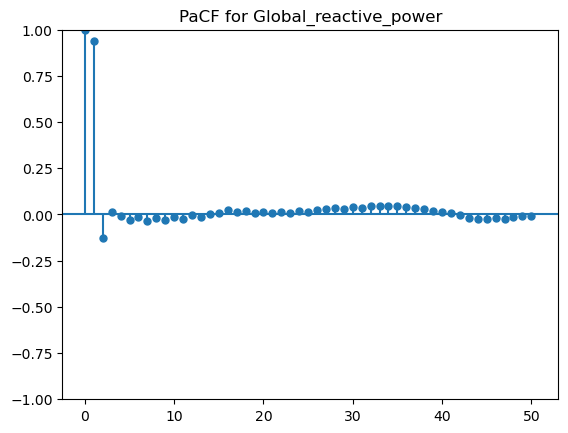

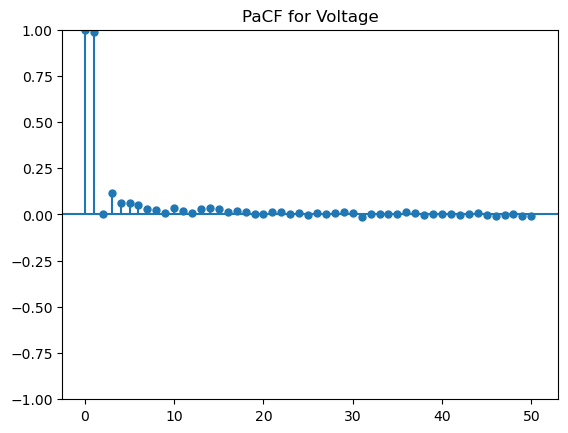

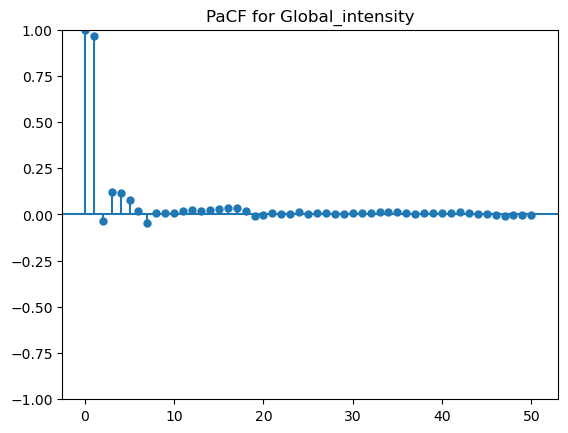

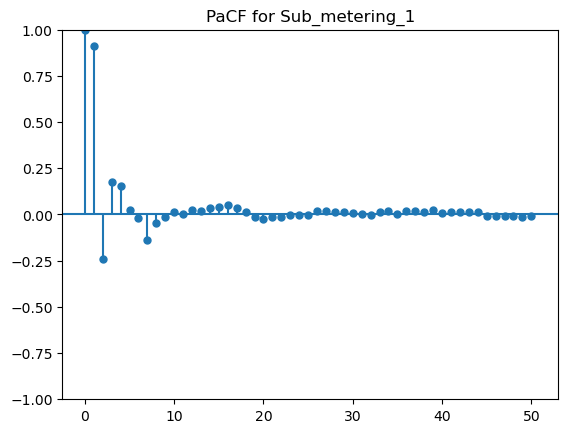

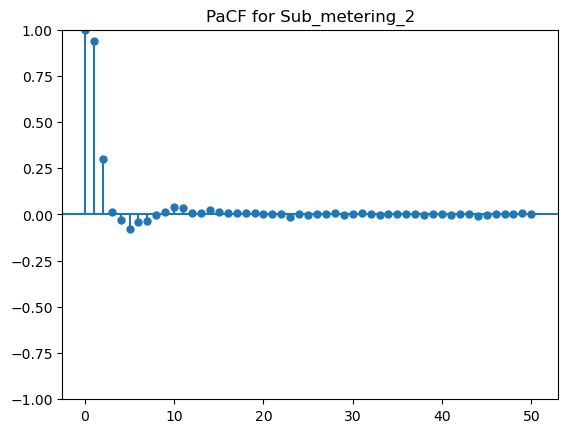

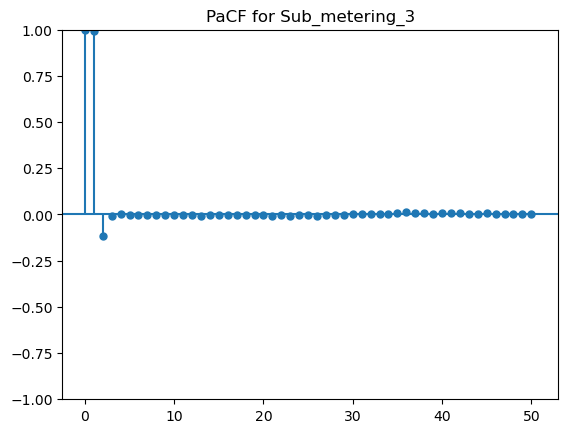

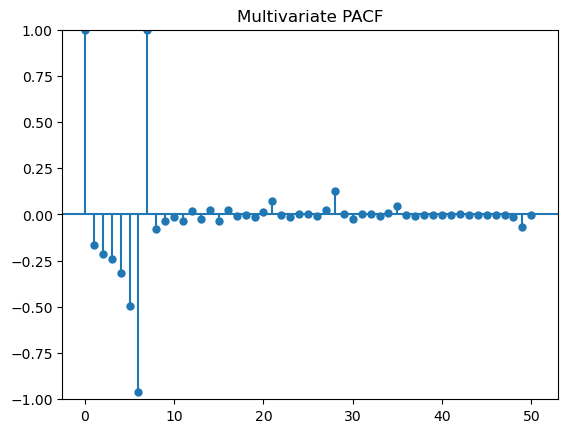

In [8]:
for column in df1.columns:
    sm.graphics.tsa.plot_pacf(df1[column].dropna(), lags=50)
    plt.title(f"PaCF for {column}")
    plt.show()
combined_series = df1.stack().reset_index(drop=True)

# Calculate multivariate ACF
sm.graphics.tsa.plot_pacf(combined_series, lags=50)
plt.title("Multivariate PACF")
plt.show()

In [ ]:
%%time
for cols in df.columns:
    adf_test = adfuller(df1[cols].dropna())
    print(f'p-value: {adf_test[1]}')
    if adf_test[1] <= 0.05:
        print("The data is stationary")
    else:
        print("non-stationary column is", cols)

In [6]:
if adf_test[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary.")

The data is stationary.


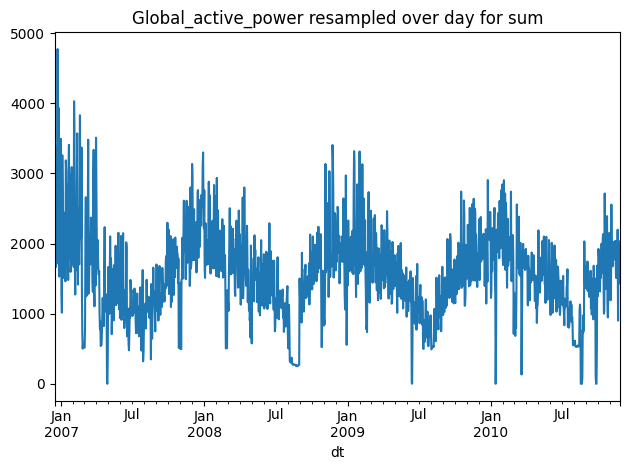

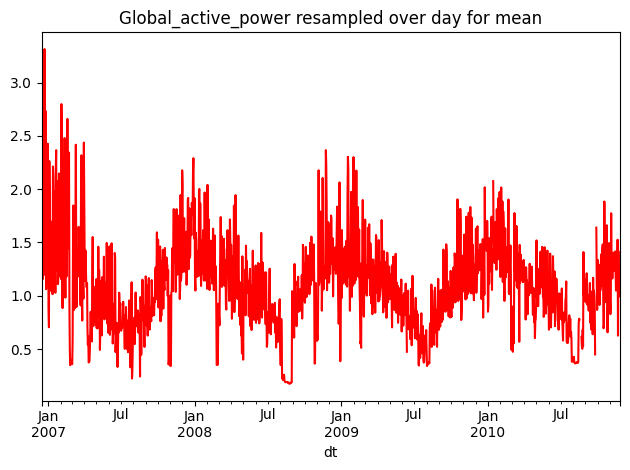

In [169]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
plt.tight_layout()
plt.show() 

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show() 

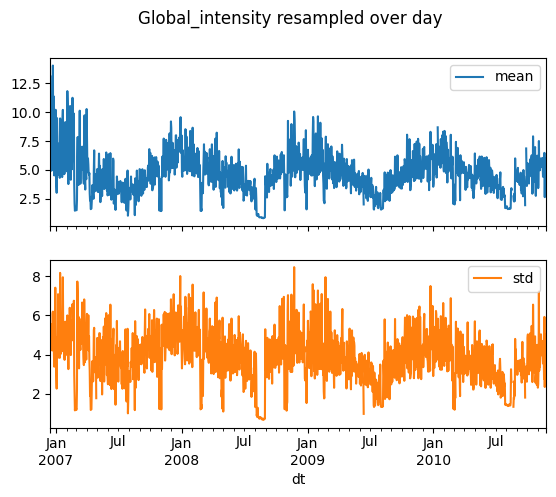

In [170]:
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

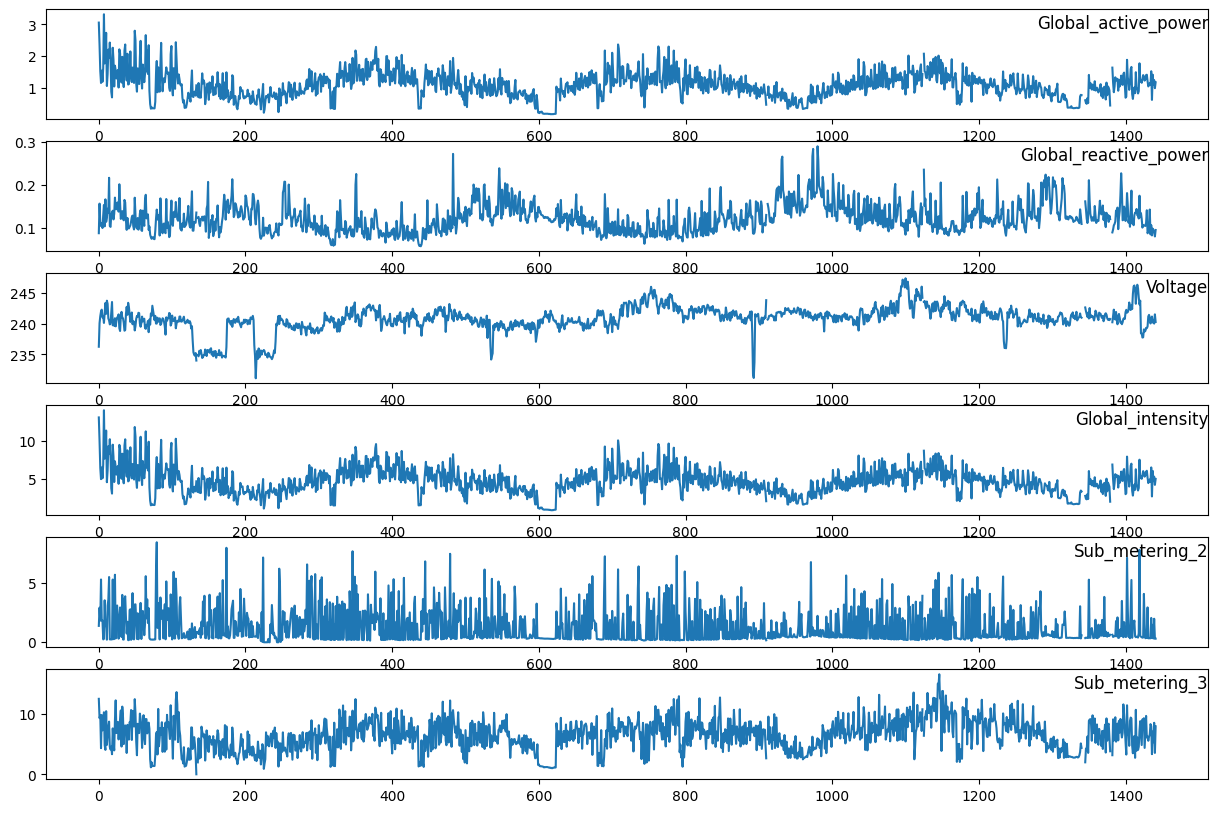

In [171]:
# Below I compare the mean of different featuresresampled over day. 
# specify columns to plot
cols = [0, 1, 2, 3, 5, 6]
i = 1
groups=cols
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
    plt.subplot(len(cols), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.75, loc='right')
    i += 1
plt.show()

In [ ]:
# ## The correlations between 'Global_intensity', 'Global_active_power'
# data_returns = df.pct_change()
# sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  

# plt.show

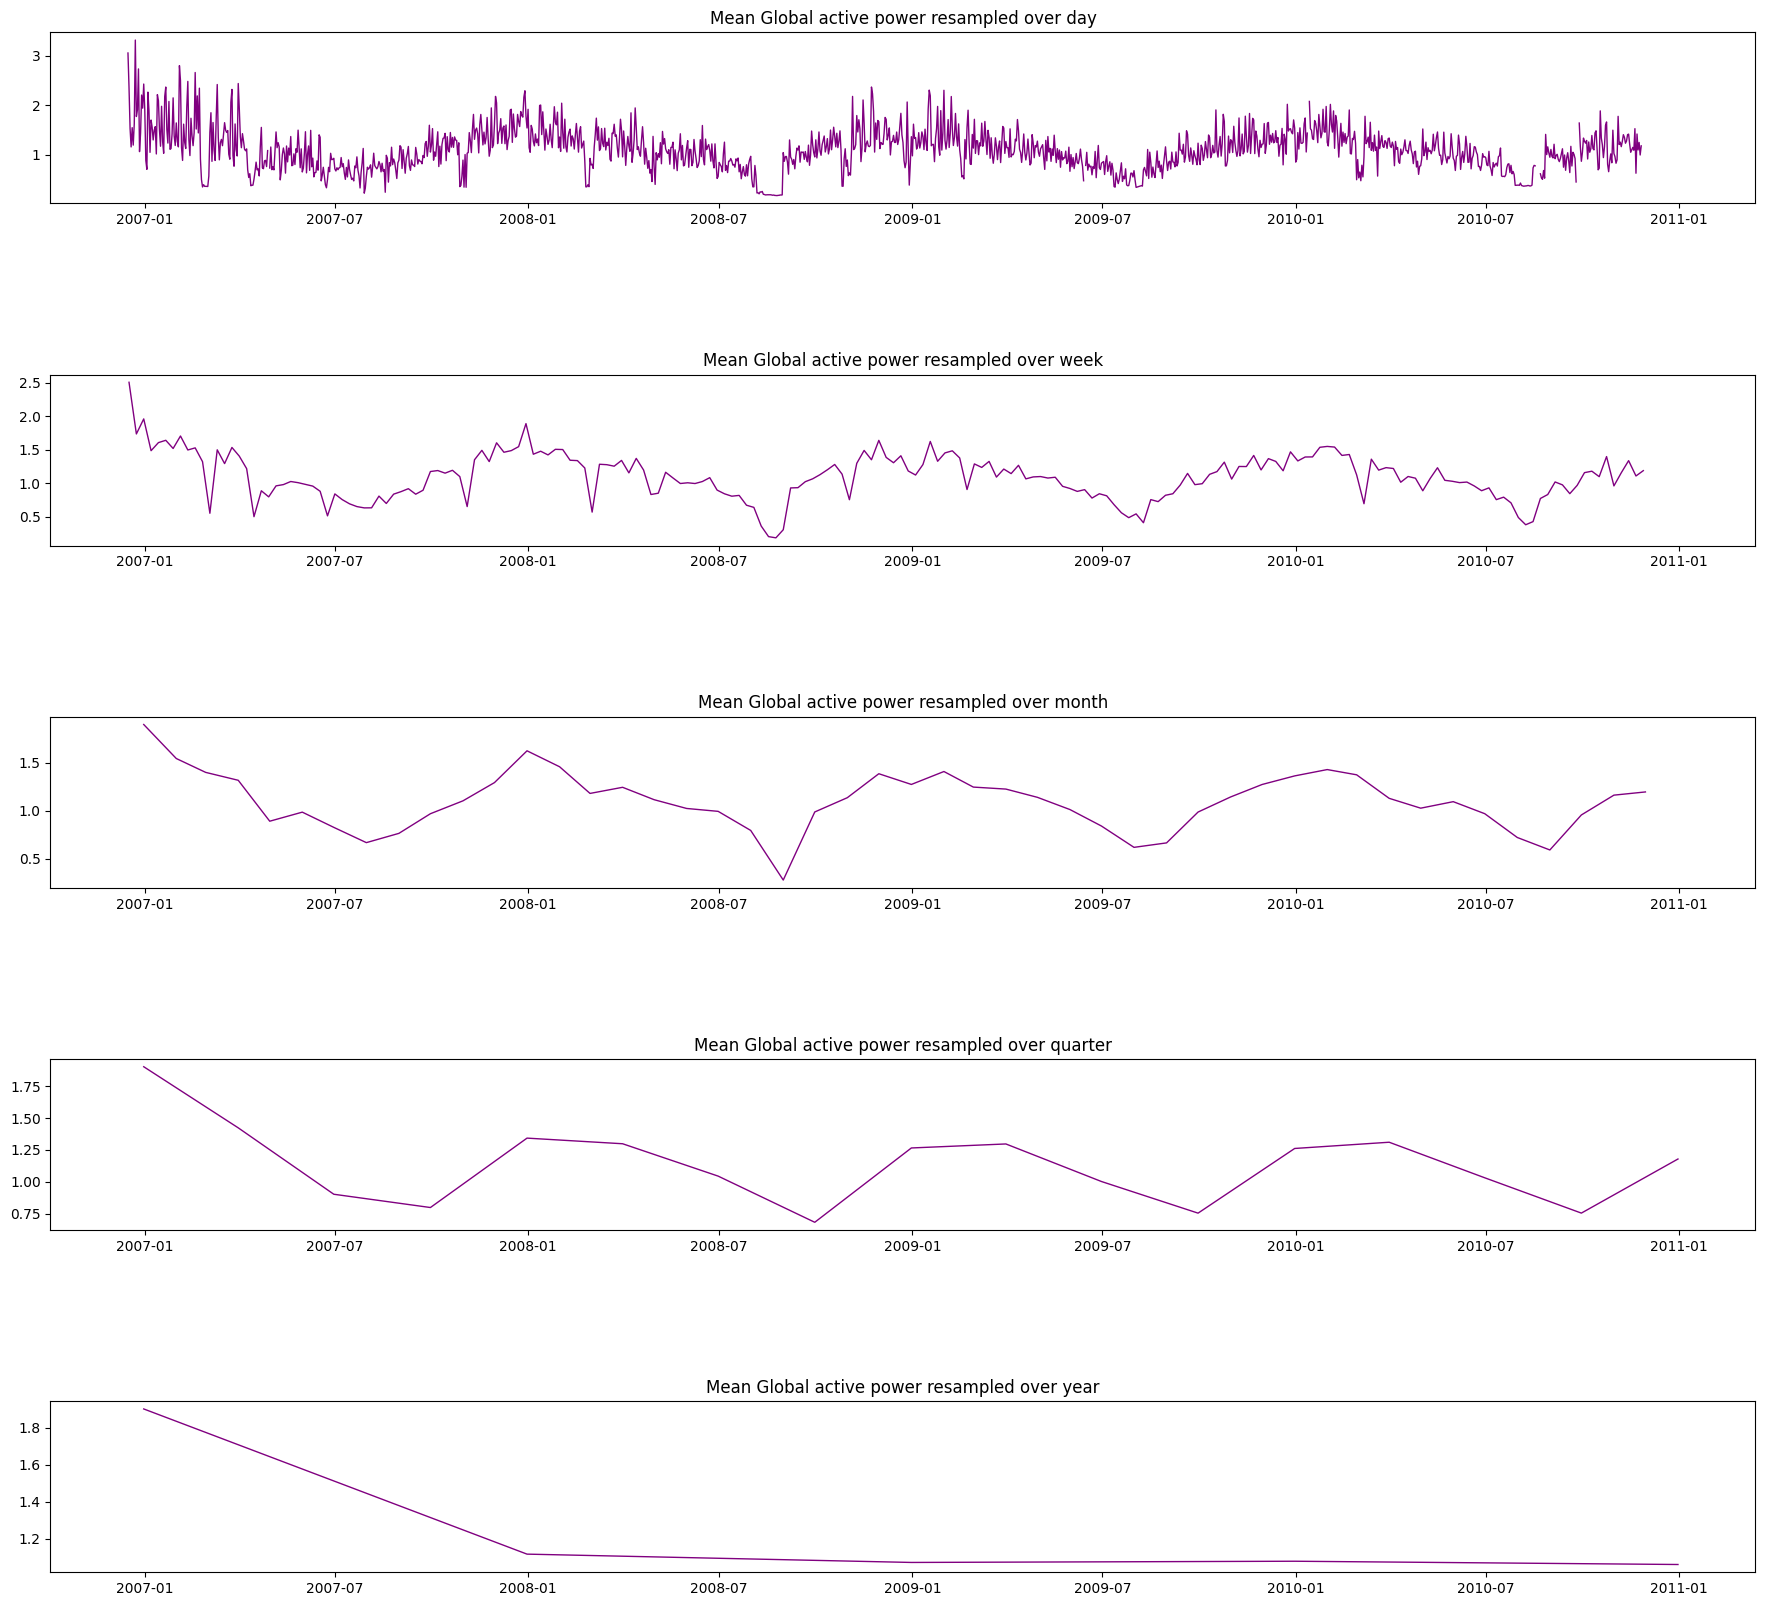

In [175]:
# Create a figure with specified size
fig = plt.figure(figsize=(22,20))
# Adjust the subplot spacing
fig.subplots_adjust(hspace=1)

# Create first subplot
ax1 = fig.add_subplot(5,1,1)
# Plot the resampled mean of Global_active_power over day with different color
ax1.plot(df['Global_active_power'].resample('D').mean(), linewidth=1, color='purple')
# Set the title for the subplot
ax1.set_title('Mean Global active power resampled over day')
# Set major tick parameters for the subplot
ax1.tick_params(axis='both', which='major')

# Create second subplot
ax2 = fig.add_subplot(5,1,2, sharex=ax1)
# Plot the resampled mean of Global_active_power over week with different color
ax2.plot(df['Global_active_power'].resample('W').mean(), linewidth=1, color='purple')
# Set the title for the subplot
ax2.set_title('Mean Global active power resampled over week')
# Set major tick parameters for the subplot
ax2.tick_params(axis='both', which='major')

# Create third subplot
ax3 = fig.add_subplot(5,1,3, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax3.plot(df['Global_active_power'].resample('M').mean(), linewidth=1, color='purple')
# Set the title for the subplot
ax3.set_title('Mean Global active power resampled over month')
# Set major tick parameters for the subplot
ax3.tick_params(axis='both', which='major')

# Create third subplot
ax4  = fig.add_subplot(5,1,4, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax4.plot(df['Global_active_power'].resample('Q').mean(),linewidth=1, color='purple')
# Set the title for the subplot
ax4.set_title('Mean Global active power resampled over quarter')
# Set major tick parameters for the subplot
ax4.tick_params(axis='both', which='major')


# Create third subplot
ax5  = fig.add_subplot(5,1,5, sharex=ax1)
# Plot the resampled mean of Global_active_power over month with different color
ax5.plot(df['Global_active_power'].resample('A').mean(),linewidth=1, color='purple')
# Set the title for the subplot
ax5.set_title('Mean Global active power resampled over year')
# Set major tick parameters for the subplot
ax5.tick_params(axis='both', which='major')


In [9]:
def date_transform(data):
    df['Hour'] = df.index.hour
    df['Dayofweek'] = df.index.dayofweek
    df['Dayofmonth'] = df.index.day
    df['Dayofyear'] = df.index.dayofyear
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    eq1 = (df['Global_active_power']*1000/60) 
    eq2 = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
    df['power_consumption'] = eq1 - eq2
    df['min']=df[Features].min(axis=1)
    df['max']=df[Features].max(axis=1)
    df['mean']=df[Features].mean(axis=1)
    df['std']=df[Features].std(axis=1)
    return df

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    data.drop(col,axis=1,inplace = True)
    return data

In [10]:
newdf =date_transform(df)
newdf = encode(newdf,'Hour',24)
newdf = encode(newdf,'Dayofweek',7)
newdf = encode(newdf,'Dayofmonth',30)
newdf = encode(newdf,'Month',12)
newdf = encode(newdf,'Dayofyear',365)

#### Auto Regression

In [12]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR
lag_order=20
model =VAR(newdf)
results =model.fit(lag_order)

In [21]:
####
forecast_steps = 12
forecast = results.forecast(newdf.values[-lag_order:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, columns=newdf.columns)

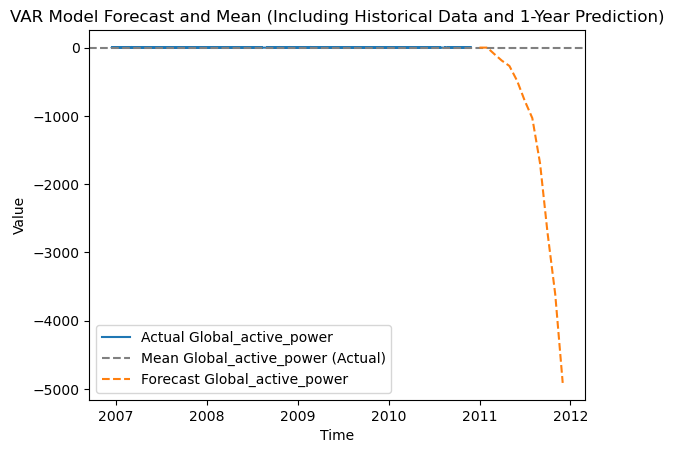

In [23]:
variable_to_plot = 'Global_active_power'  # Change this to the variable you want to plot
variable_mean = newdf[variable_to_plot].mean()

# Plot the actual data, mean, and forecasted values for 2 years
plt.plot(newdf.index, newdf[variable_to_plot], label='Actual ' + variable_to_plot)
plt.axhline(y=variable_mean, color='gray', linestyle='dashed', label='Mean ' + variable_to_plot + ' (Actual)')
plt.plot(pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast_df[variable_to_plot], label='Forecast ' + variable_to_plot, linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('VAR Model Forecast and Mean (Including Historical Data and 1-Year Prediction)')
plt.legend()
plt.show()

#### XGB

In [ ]:
X=newdf.drop('Global_active_power', axis=1)
y=newdf['Global_active_power']
y.reset_index(drop=True, inplace=True)

train_percentage = 0.8
split_point = int(len(df) * train_percentage)
train_data = X.iloc[:split_point]
test_data = X.iloc[split_point:]
train_y =y.iloc[:split_point]
test_y =y.iloc[split_point:]

In [52]:
from xgboost import XGBRegressor
xgb = XGBRegressor(objective='reg:linear', seed=42)
eval_set=[(train_data, train_y),(test_data,test_y),]
xgb.fit(train_data, train_y,
          early_stopping_rounds=200,
          eval_set=eval_set,
          eval_metric='mae',
          verbose=True)

[19:35:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.56366	validation_1-mae:0.46835
[1]	validation_0-mae:0.39521	validation_1-mae:0.32723
[2]	validation_0-mae:0.27764	validation_1-mae:0.22905
[3]	validation_0-mae:0.19571	validation_1-mae:0.16073
[4]	validation_0-mae:0.13875	validation_1-mae:0.11371
[5]	validation_0-mae:0.09919	validation_1-mae:0.08128
[6]	validation_0-mae:0.07188	validation_1-mae:0.05954
[7]	validation_0-mae:0.05311	validation_1-mae:0.04485
[8]	validation_0-mae:0.04046	validation_1-mae:0.03503
[9]	validation_0-mae:0.03196	validation_1-mae:0.02860
[10]	validation_0-mae:0.02611	validation_1-mae:0.02428
[11]	validation_0-mae:0.02228	validation_1-mae:0.02132
[12]	validation_0-mae:0.01997	validation_1-mae:0.01959
[13]	validation_0-mae:0.01837	validation_1-mae:0.01824
[14]	validation_0-mae:0.01730	validation_1-mae:0.01747
[15]	validation_0-mae:0.01653	validation_1-mae:0.01677
[16]	valida

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [53]:
### prediction from xgboost
y_pred = xgb.predict(test_data)
xg_score  = r2_score(test_y, y_pred)
xg_score

0.9994793335965447

In [54]:
xg_mean=mean_absolute_error(test_y, y_pred)
xg_mean

0.010695466

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU,LSTM,BatchNormalization,Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import RobustScaler, normalize

#### GRU Model

In [ ]:
RS = RobustScaler()
train_df=RS.fit_transform(X)

In [ ]:
train_percentage = 0.8
split_point = int(len(train_df) * train_percentage)

X_train = train_df[:split_point]
X_test = train_df[split_point:]

y_train = y[:split_point]
y_test = y[split_point:]

In [ ]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [39]:
# def build_model():
#     inp = tf.keras.Input(shape=X_train_reshaped.shape[-2:])
    
#     x = tf.keras.layers.GRU(units=512, return_sequences=True)(inp)
#     x = tf.keras.layers.ReLU()(x)
#     x = tf.keras.layers.GRU(units=512, return_sequences=True)(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = tf.keras.layers.GRU(units=256, return_sequences=True)(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = tf.keras.layers.GRU(units=128, return_sequences=False)(x)
#     x = tf.keras.layers.ReLU()(x)
#     x = tf.keras.layers.Dense(1)(x) # # Output layer for regression
#     model = tf.keras.Model(inputs=inp, outputs=x)
    
#     opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
#     loss = tf.keras.losses.MeanSquaredError()
#     model.compile(loss=loss, optimizer = opt)
    
#     return model

In [43]:
gru = Sequential()
gru.add(GRU(units=128, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
gru.add(Dropout(0.2))
gru.add(BatchNormalization())
gru.add(GRU(units=64, activation='relu', return_sequences=True))
gru.add(Dropout(0.2))
gru.add(BatchNormalization())
gru.add(GRU(units=32, activation='relu'))
gru.add(Dropout(0.2))
gru.add(BatchNormalization())
gru.add(Dense(units=1, activation='linear', kernel_regularizer=l2(0.01)))
gru.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 23, 128)           50304     
                                                                 
 dropout_6 (Dropout)         (None, 23, 128)           0         
                                                                 
 batch_normalization_6 (Batc  (None, 23, 128)          512       
 hNormalization)                                                 
                                                                 
 gru_5 (GRU)                 (None, 23, 64)            37248     
                                                                 
 dropout_7 (Dropout)         (None, 23, 64)            0         
                                                                 
 batch_normalization_7 (Batc  (None, 23, 64)           256       
 hNormalization)                                      

In [41]:
lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
es = EarlyStopping(monitor="val_loss", patience=60, verbose=1, mode="min", restore_best_weights=True)

In [44]:
EPOCH = 2
BATCH_SIZE = 256
gru.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es])

Epoch 1/2
6486/6486 [==============================] - 1096s 168ms/step - loss: 0.0975 - val_loss: 0.0199 - lr: 0.0010
Epoch 2/2
6486/6486 [==============================] - 1088s 168ms/step - loss: 0.0319 - val_loss: 0.0098 - lr: 0.0010


In [46]:
predictions = model.predict(X_test).reshape(-1)
mae_gru = mean_absolute_error(predictions, y_test)
print("Mean Absolute MAE", mae_gru)

12971/12971 [==============================] - 1430s 110ms/step
Mean Absolute MAE 0.16630894


#### LSTM

In [28]:
lstm = Sequential()
lstm.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm.add(Dropout(0.2))
lstm.add(BatchNormalization())
lstm.add(LSTM(units=64, activation='relu', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(BatchNormalization())
lstm.add(LSTM(units=32, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(BatchNormalization())
lstm.add(Dense(units=1, activation='linear', kernel_regularizer=l2(0.01)))
lstm.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 23, 128)           66560     
                                                                 
 dropout_3 (Dropout)         (None, 23, 128)           0         
                                                                 
 batch_normalization_3 (Batc  (None, 23, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_4 (LSTM)               (None, 23, 64)            49408     
                                                                 
 dropout_4 (Dropout)         (None, 23, 64)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 23, 64)           256       
 hNormalization)                                      

In [29]:
lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
es = EarlyStopping(monitor="val_loss", patience=60, verbose=1, mode="min", restore_best_weights=True)

In [30]:
EPOCH = 5
BATCH_SIZE = 256
lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es])

Epoch 1/5
6486/6486 [==============================] - 1303s 200ms/step - loss: 0.1270 - val_loss: 0.0096 - lr: 0.0010
Epoch 2/5
6486/6486 [==============================] - 1301s 201ms/step - loss: 0.0341 - val_loss: 0.0048 - lr: 0.0010
Epoch 3/5
6486/6486 [==============================] - 1299s 200ms/step - loss: 0.0301 - val_loss: 0.0098 - lr: 0.0010
Epoch 4/5
6486/6486 [==============================] - 1301s 201ms/step - loss: 0.0281 - val_loss: 0.0123 - lr: 0.0010
Epoch 5/5
6486/6486 [==============================] - 1295s 200ms/step - loss: 0.0274 - val_loss: 0.0132 - lr: 0.0010


In [56]:
predictions = lstm.predict(X_test).reshape(-1)
mae_lstm = mean_absolute_error(predictions, y_test)
print(" Mean Absolute:", mae_lstm)

12971/12971 [==============================] - 259s 20ms/step
 Mean Absolute: 0.08323641


#### Lasso Regression

In [60]:
train_percentage = 0.8
split_point = int(len(df) * train_percentage)
train_data = X.iloc[:split_point]
test_data = X.iloc[split_point:]
train_y =y.iloc[:split_point]
test_y =y.iloc[split_point:]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_data)
X_test_scaled = scaler.transform(test_data)

In [61]:
lasso = Lasso(alpha=1)
lasso.fit(X_train_scaled, train_y)

Lasso(alpha=1)

In [64]:
y_pred = lasso.predict(X_test_scaled)

# Evaluate the model
mse = mean_absolute_error(y_pred, test_y)
print(f'Mean Absulate Error: {mse}')

Mean Absulate Error: 0.6425346121709908


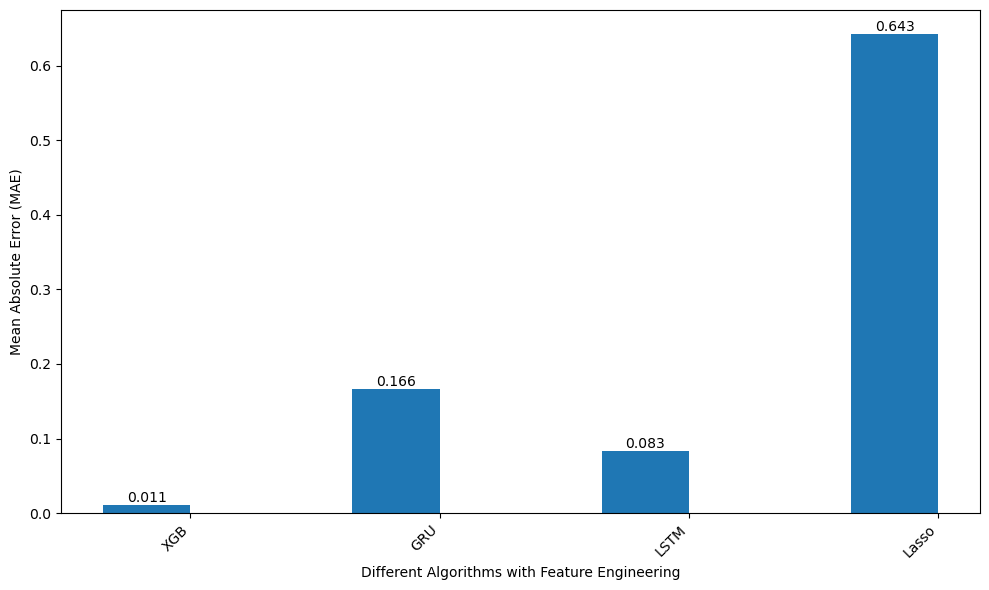

In [3]:
algorithms = ['XGB','GRU', 'LSTM','Lasso']

# mlp_mae xg_mae ada_mae dt_mae svr_mae knn_mae lr_mae
mae = [xg_mean,mae_gru,mae_lstm,mse]

# Bar plot comparing MAE loss with different algorithms
plt.figure(figsize=(10, 6))
width = 0.35
bars1 = plt.bar(np.arange(len(algorithms)), mae, width)
plt.xticks(np.arange(len(algorithms)) + width / 2, algorithms, rotation=45, ha='right')
plt.xlabel('Different Algorithms with Feature Engineering')
plt.ylabel('Mean Absolute Error (MAE)')

# Add values on top of each bar
for bar in bars1:
    height1 = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height1, f'{height1:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Occapancy & Detection

In [142]:
test = pd.read_csv("/kaggle/input/taskdata/Multi-Variate/Multi-Variate/occupancy+detection/datatest2.txt")
train =pd.read_csv("/kaggle/input/taskdata/Multi-Variate/Multi-Variate/occupancy+detection/datatraining.txt")

In [115]:
# train.set_index('date', inplace=True) 
train['Occupancy'].value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

In [143]:
train['date'] = pd.to_datetime(train['date'])
train.reset_index(drop=True, inplace=True)

<Axes: title={'center': 'Occupancy Distribution'}, xlabel='Occupancy', ylabel='count'>

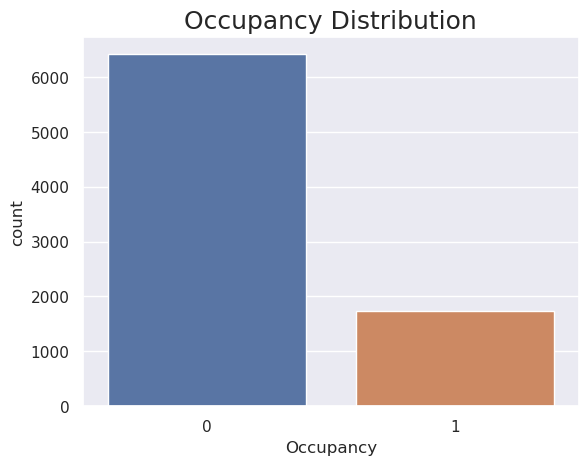

In [84]:
sns.set(style="darkgrid")
plt.title("Occupancy Distribution", fontdict={'fontsize':18})
sns.countplot(x="Occupancy", data=train)

In [14]:
#no missing values
train.isna().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [79]:
adf_results = {}
for column in train.columns:
    result = sm.tsa.adfuller(train[column].dropna())
    adf_results[column] = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }
if result[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary.")

The data is stationary.


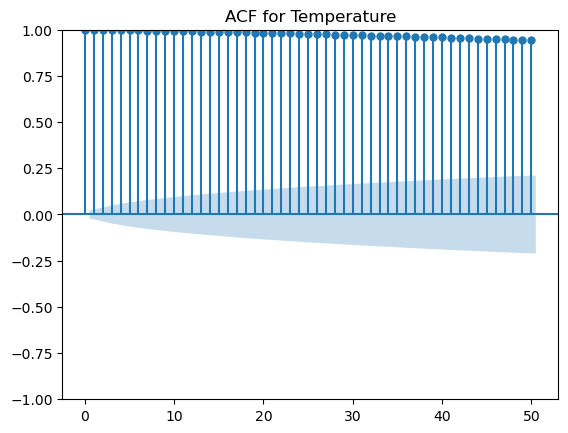

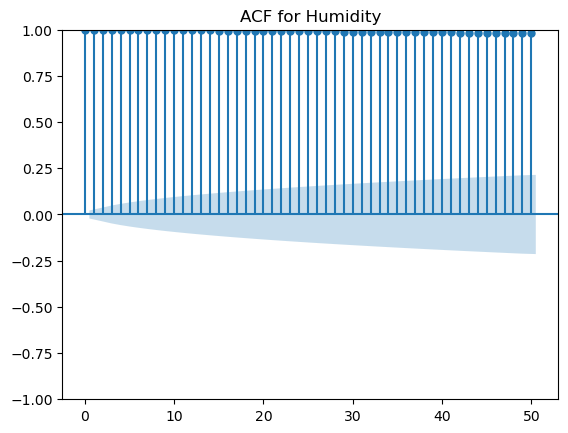

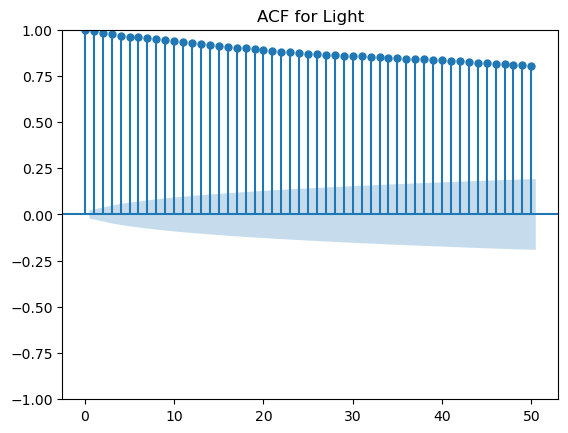

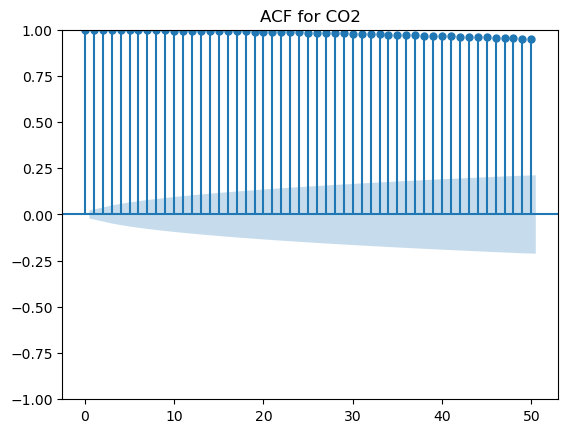

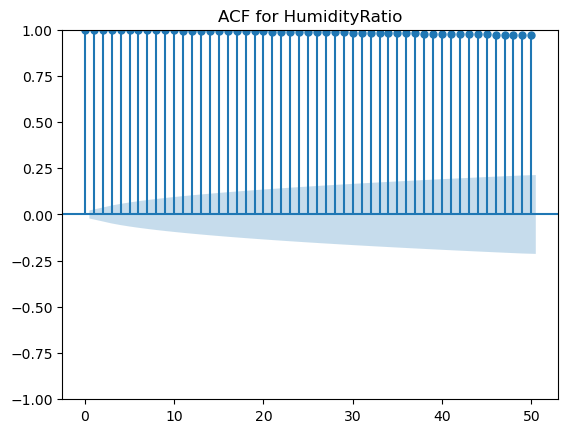

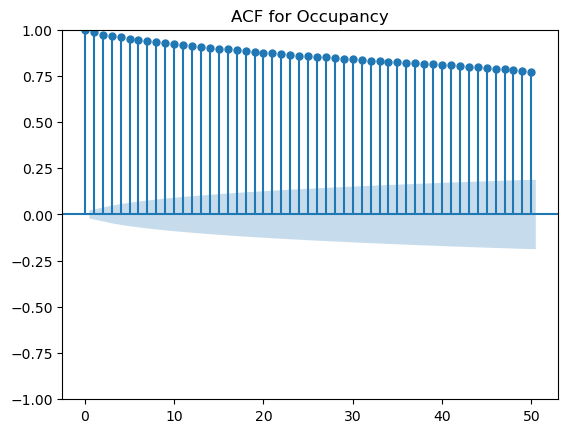

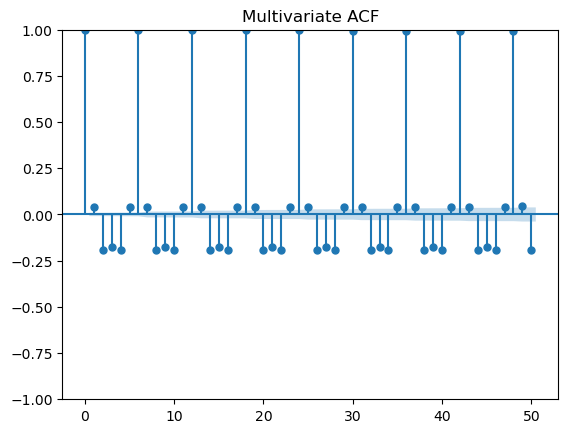

In [80]:
for column in train.columns:
    sm.graphics.tsa.plot_acf(train[column].dropna(), lags=50)
    plt.title(f"ACF for {column}")
    plt.show()

# Combine all columns into a single series for multivariate ACF
combined_series = train.stack().reset_index(drop=True)

# Calculate multivariate ACF
sm.graphics.tsa.plot_acf(combined_series, lags=50)
plt.title("Multivariate ACF")
plt.show()

In [ ]:
hours_1 = []
hours_0 = []
for date in train[train['Occupancy'] == 1]['date']:
    hours_1.append(date.hour)
for date in train[train['Occupancy'] == 0]['date']:
    hours_0.append(date.hour)

<Axes: ylabel='Density'>

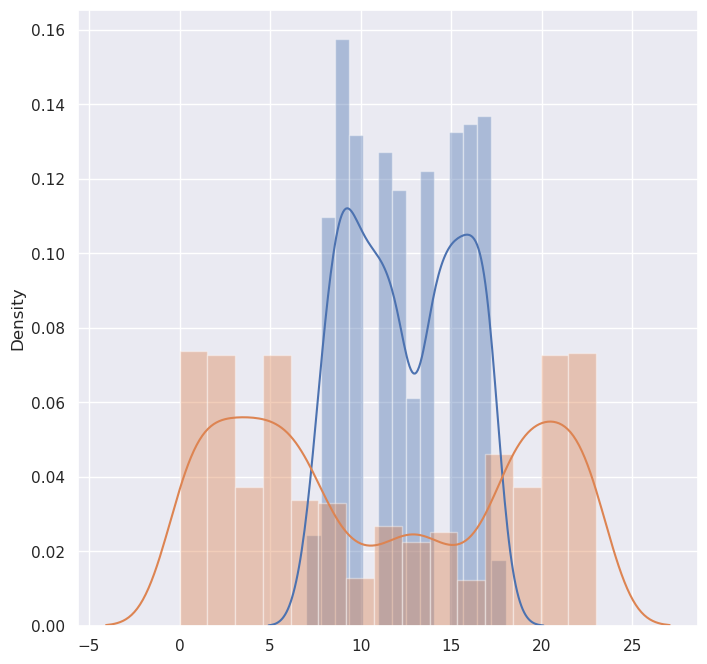

In [94]:
plt.figure(figsize=(8,8))
sns.distplot(hours_1)
sns.distplot(hours_0)

#### Handle class Imbalance

In [224]:
from imblearn.combine import SMOTEENN
import tensorflow as tf

In [163]:
train['month'] = pd.DatetimeIndex(train['date']).month
train['day'] = pd.DatetimeIndex(train['date']).day
train['quarter'] = pd.DatetimeIndex(train['date']).quarter
train['year'] = pd.DatetimeIndex(train['date']).year

In [169]:
X=train.drop(['Occupancy', 'date'], axis=1)
y=train['Occupancy']

In [175]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

In [176]:
train_percentage = 0.8
split_point = int(len(X_resampled) * train_percentage)

X_train = X_resampled[:split_point]
X_test = X_resampled[split_point:]

y_train = y_resampled[:split_point]
y_test = y_resampled[split_point:]

In [186]:
import xgboost as xgb
params = {
            'objective' : 'binary:logistic',
            'tree_method': 'hist',
            'eval_metric': 'logloss',
            'n_estimators':300,
            'predictor': 'cpu_predictor'
        }       
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train,
          early_stopping_rounds=200,
          eval_set=[(X_test,y_test)],
          verbose=True)

[0]	validation_0-logloss:0.43952
[1]	validation_0-logloss:0.29905
[2]	validation_0-logloss:0.21009
[3]	validation_0-logloss:0.15046
[4]	validation_0-logloss:0.10918
[5]	validation_0-logloss:0.08020
[6]	validation_0-logloss:0.05924
[7]	validation_0-logloss:0.04413
[8]	validation_0-logloss:0.03318
[9]	validation_0-logloss:0.02510
[10]	validation_0-logloss:0.01905
[11]	validation_0-logloss:0.01472
[12]	validation_0-logloss:0.01154
[13]	validation_0-logloss:0.00913
[14]	validation_0-logloss:0.00739
[15]	validation_0-logloss:0.00608
[16]	validation_0-logloss:0.00513
[17]	validation_0-logloss:0.00443
[18]	validation_0-logloss:0.00385
[19]	validation_0-logloss:0.00345
[20]	validation_0-logloss:0.00311
[21]	validation_0-logloss:0.00280
[22]	validation_0-logloss:0.00263
[23]	validation_0-logloss:0.00248
[24]	validation_0-logloss:0.00230
[25]	validation_0-logloss:0.00216
[26]	validation_0-logloss:0.00203
[27]	validation_0-logloss:0.00194
[28]	validation_0-logloss:0.00183
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor='cpu_predictor',
              random_state=None, ...)

In [189]:
y_pred = model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred)
acc_xgb

0.9996056782334385

#### LSTM

In [194]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dropout, BatchNormalization, Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler

In [220]:
def custom_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

In [195]:
Ms=MinMaxScaler()
train_res=Ms.fit_transform(X_train)
test_res=Ms.fit_transform(X_test)

In [196]:
X_train_reshaped = train_res.reshape((train_res.shape[0], train_res.shape[1], 1))
X_test_reshaped = test_res.reshape((test_res.shape[0], test_res.shape[1], 1))

In [226]:
lstm = Sequential()

lstm.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm.add(Dropout(0.2))
lstm.add(BatchNormalization())

lstm.add(LSTM(units=64, activation='relu', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(BatchNormalization())

lstm.add(LSTM(units=32, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(BatchNormalization())

# For binary classification, use 'sigmoid' activation in the output layer
lstm.add(Dense(units=1, activation='sigmoid'))  # Sigmoid activation for binary classification

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 9, 128)            66560     
                                                                 
 dropout_15 (Dropout)        (None, 9, 128)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 9, 128)           512       
 chNormalization)                                                
                                                                 
 lstm_13 (LSTM)              (None, 9, 64)             49408     
                                                                 
 dropout_16 (Dropout)        (None, 9, 64)             0         
                                                                 
 batch_normalization_16 (Bat  (None, 9, 64)            256       
 chNormalization)                                     

In [227]:
lr_schedule = LearningRateScheduler(custom_scheduler)
EPOCH = 30
BATCH_SIZE = 64
lstm.fit(X_train_reshaped,y_train, epochs=EPOCH, batch_size=BATCH_SIZE,validation_split=0.2, callbacks=[lr_schedule])

Epoch 1/30
127/127 [==============================] - 12s 50ms/step - loss: 0.2424 - accuracy: 0.9135 - val_loss: 1.2790 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/30
127/127 [==============================] - 6s 44ms/step - loss: 0.0656 - accuracy: 0.9885 - val_loss: 2.4586 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/30
127/127 [==============================] - 6s 44ms/step - loss: 0.0431 - accuracy: 0.9925 - val_loss: 4.0857 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/30
127/127 [==============================] - 6s 47ms/step - loss: 0.0304 - accuracy: 0.9947 - val_loss: 4.9364 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/30
127/127 [==============================] - 6s 45ms/step - loss: 0.0278 - accuracy: 0.9949 - val_loss: 1.0485 - val_accuracy: 0.3080 - lr: 0.0010
Epoch 6/30
127/127 [==============================] - 6s 45ms/step - loss: 0.0223 - accuracy: 0.9947 - val_loss: 0.1883 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 7/30
127/127 [===========================

In [228]:
loss, accuracy = lstm.evaluate(X_test_reshaped, y_test)

print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

80/80 [==============================] - 1s 11ms/step - loss: 0.3844 - accuracy: 0.9444
Test loss: 0.3844
Test accuracy: 0.9444


#### GRU

In [204]:
gru = Sequential()

gru.add(GRU(units=128, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
gru.add(Dropout(0.2))
gru.add(BatchNormalization())

gru.add(GRU(units=64, activation='relu', return_sequences=True))
gru.add(Dropout(0.2))
gru.add(BatchNormalization())

gru.add(GRU(units=32, activation='relu'))
gru.add(Dropout(0.2))
gru.add(BatchNormalization())

gru.add(Dense(units=1, activation='sigmoid'))  

gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 9, 128)            50304     
                                                                 
 dropout_9 (Dropout)         (None, 9, 128)            0         
                                                                 
 batch_normalization_9 (Batc  (None, 9, 128)           512       
 hNormalization)                                                 
                                                                 
 gru_1 (GRU)                 (None, 9, 64)             37248     
                                                                 
 dropout_10 (Dropout)        (None, 9, 64)             0         
                                                                 
 batch_normalization_10 (Bat  (None, 9, 64)            256       
 chNormalization)                                     

In [205]:
EPOCH = 30
BATCH_SIZE = 64
gru.fit(X_train_reshaped,y_train, epochs=EPOCH, batch_size=BATCH_SIZE,validation_split=0.2, callbacks=[lr_schedule])

Epoch 1/30
127/127 [==============================] - 12s 46ms/step - loss: 0.2099 - accuracy: 0.9270 - val_loss: 1.4377 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/30
127/127 [==============================] - 5s 42ms/step - loss: 0.0514 - accuracy: 0.9925 - val_loss: 2.3954 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/30
127/127 [==============================] - 5s 41ms/step - loss: 0.0360 - accuracy: 0.9936 - val_loss: 3.4251 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/30
127/127 [==============================] - 5s 41ms/step - loss: 0.0260 - accuracy: 0.9943 - val_loss: 3.1342 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/30
127/127 [==============================] - 5s 41ms/step - loss: 0.0244 - accuracy: 0.9953 - val_loss: 0.2643 - val_accuracy: 0.8990 - lr: 0.0010
Epoch 6/30
127/127 [==============================] - 5s 40ms/step - loss: 0.0229 - accuracy: 0.9957 - val_loss: 0.0136 - val_accuracy: 0.9941 - lr: 0.0010
Epoch 7/30
127/127 [===========================

In [206]:
loss, accuracy = gru.evaluate(X_test_reshaped, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

80/80 [==============================] - 1s 8ms/step - loss: 0.2798 - accuracy: 0.9535
Test loss: 0.2798
Test accuracy: 0.9535
